<a href="https://colab.research.google.com/github/Seb125/MFCC_Genres/blob/main/Genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Feature engeneering: Calculating mfcc's for each audio file

In [ ]:
import os
import librosa
import math
import json

DATASET_PATH = "Genres"
JSON_PATH = "data.json"

SAMPLE_RATE = 22050
DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION


# json_path: path to the file where we store all mfccs and the labels
# each track is chopped into 10 segments

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    
    # dictionary to store data
    data = {
      "mapping": [], # classical is mapped to indice 0
      "mfcc": [], # mfccs for each segment
      "labels":[]  # target (first segment is classical, second, classical....)

    }
    
    num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)
    
    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # esnure that we're not at the root/dataset level
        if dirpath is not dataset_path:   #dirpath gives path of current directory
            
            # save the semantic label
            dirpath_components = dirpath.split("/") # genre/blues => ["genre", "blues"]
            semantic_label = dirpath_components[-1]  # last entry of dirpath_components
            data["mapping"].append(semantic_label)
            print("\nProcessing {}".format(semantic_label))

            # process files for a specific genre
            for f in filenames:
                
                #load audio file
                file_path = os.path.join(dirpath, f)
                print(file_path)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                
                # process segments extracting mfcc and storing data
                for s in range(num_segments):
                    start_sample = num_samples_per_segment * s # s = 0 -> 0
                    finish_sample = start_sample + num_samples_per_segment # s = 0 -> num_samples_per_segment

          
                    mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                                      sr=sr,
                                                      n_fft=n_fft,
                                                      n_mfcc=n_mfcc,
                                                      hop_length=hop_length)
                    
                    mfcc = mfcc.T  # transpose -> mfcc vectors are columns
                    
                    
                    # store mfcc for segment if it has the expected length
                    if len(mfcc) == expected_num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1) # cause the first iteration is at the root level
                        print("{}, segment:{}".format(file_path, s))
   
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

## Trying different classifiers (MLP, SVM, KNN) on the flattened feature vectors

In [44]:
import json
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import svm, metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score


DATASET_PATH = "data10.json"

def load_data(dataset_path):
    with open(dataset_path, "r") as fp: # r = read
        data = json.load(fp)
        
    # convert lists into numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs, targets


In [45]:
#load data
inputs, targets = load_data(DATASET_PATH)

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3)

### Flattening and Normalizing Input vectors

In [46]:
from sklearn.preprocessing import StandardScaler

# Reshape inputs: Inputs have 3 dimensions (0:segments, 1:mfcc windows in each segment, 2:mff vectors)
# for each segment we concatenate all mfcc vectors

# inputs_train.shape = (699, 130, 13) inputs_train_reshaped.shape = (699, 1690)
X_train_reshaped = X_train.reshape(699,1690)
# inputs_train.shape = (300, 130, 13) inputs_train_reshaped.shape = (300, 1690)
X_test_reshaped = X_test.reshape(300,1690)

# normalizing input features
X_train = StandardScaler().fit_transform(X_train_reshaped)
X_test = StandardScaler().fit_transform(X_test_reshaped)

Our input vectors live in $R^{1690}$, which is quite high dimensional compared to the number of samples (900). This is a scenario where kernel methods are of great use. 

# Kernel methods (https://bloom.bg/2ui2T4q)

## Motivation

Mapping from an input space $\chi$ to a vector in $R^d$ is called feature extraction.  
Feature mapping is a function of the form $\psi: \chi -> R^d$.  
To get expressive hypothesis spaces using linear models we need high-dimensional feature spaces. Suppose we start with $x= (1, x_1, ..., x_d) \in R^{d+1} = \chi$. Now with our feature mapping $\psi(x)$ we want all monomials of degree M. Then we will end up with the number of features of $O(d^M)$?. Thus we will get extremely large matrices. Having large feature spaces have two problems, Overfitting (handled by regularization) and memory, computational cost. Kernel methods can (sometimes) help with memory and computational costs.


###### Definition

A method can be kernalized if inputs appear inside inner products: $\langle  \; \psi(x), \psi(x') \; \rangle$ for $x, x' \in \chi$.  
The kernel function corresponding to such an inner product is:  

$k(x,x') = \langle  \; \psi(x), \psi(x') \; \rangle$.  

Kernels as similarity scores: It is often useful to think of the kernel function as a similarity score. The final classifier is a similarity-weighted vote (see section... for details). However this is not a mathematically precise statement.



###### Different Kernels

###### Linear Kernel

Feature map: $\phi(x)  = x$  
Kernel: $k(x, x') = x^Tx'$

A linear kernel uses just the original input features. The output of the linear kernel function just gives the standard dot product between two data points $x^Tx'$. As x and x' lie in the original input space,w e don't get acces to a higher dimensional feature space by using a lienar kernel. We are using the original feature space and the kernel function does not has any computational benefits. So if our input vector already lie in high dimensional feature space, such that the data is already seperable with a linear method, I won't get any benefit form using kernel methods.(?)

###### Quadratic Kernel

Input space $\chi = R^d$  
Feature space: $H = R^D$, where $D = d + \binom{d}{2} \approx \frac{d^2}{2}$.

Feature map: 

$\psi(x) = (x_1,...,x_d,x^2_1,...x^2_d,\sqrt{2}x_1x_2,...,\sqrt{2}x_{d-1}x_d)^T$

Then for $\forall x, x' \in R^d$

$k(x,x') = \langle  \; \psi(x), \psi(x') \; \rangle = \langle  \; x, x' \; \rangle + \langle  \; x, x' \; \rangle ^2$

Computation for inner product with explicit mapping: $O(d^2)$  
Computation for implicit kernel calculation: $O(d)$.

Thus with the qudratic kernel function we can evaluate a dot product of feature space that includes all monomials up to degree 2 of the original input space, while computation cost is in the same order as for the original feature space. Notice that we have these extra coefficients ($\sqrt{2}$) in front of our features. These interact with our regularization. We can use smaller coefficients $w$ to get the same output, such that with regularization these features get favored by the model.

###### Polynomial Kernel

Input space $\chi = R^d$  
Kernel function:  

$k(x,x') = (1 + \langle  \; x, x' \; \rangle)^M$
    
Corresponds to a feature map with all monomials up to degree M.  
For any M, computing the kernel has same computationsl cost.  
Cost of explicit inner product computation grows rapidly in M. 

###### RBF/Gaussian Kernel

Input space $\chi = R^d$   
Kernel function:  

$k(x,x') = exp(-\frac{||x-x'||^2}{2\sigma^2})$ 

where $\sigma^2$ is known as the bandwith parameter. 

Does it act like a similarity score?:
For $x=x'$ the kernel evaluates to 1 and for increasing distance between x and x' the value of the functions gets closer to 0.  
Why "radial"?: The output is independent of orientation. All x's in the same radius of x get the same similarity score.  
For the RBF kernel we have in some sense departed form our "inner product of feature vector" recipe. The RBF kernel corresponds to an infinite dimensional feature vector ($\psi(x)$ has infinite number of dimensions). 
It is probably the most common nonlinear kernel. 
How does the kernel function behave if we change $\sigma^2$?:....see UCSD lecture slides!

###### The Kernel trick

We can transform certain objektive functions into a kernalized version (see details below). This kernalized objective function contains the kernel matrix.

For points $x_1,...,x_n \in \chi$ and an inner product $\langle  \; .,. \; \rangle$ on $\chi$, the kernel matrix is defined as:  

$K = (\langle  \; x_i, x_j \; \rangle)_{ij} = \left(\begin{array}{rrr} 
\langle  \; x_1, x_1 \; \rangle & ... & \langle  \; x_1, x_n \; \rangle \\ 
... & ... & ... \\ 
\langle  \; x_n, x_1 \; \rangle & ... & \langle  \; x_n, x_n \; \rangle \\ 
\end{array}\right) = XX^T$  

which is an $nxn$ matrix. 

Given a kernalized ML algorithm, we can swap out the kernel function. The new kernel may correspond to a high dimensional feature space. Once the kernel matrix is computed , the computational cost depends only on the number of data points, rather than the dimesnion of the feature space. 

In ridge regression we deel with a matrix $X^TX$ which is $dxd$. In general you would prefer to work with the smaller matrix. Thus kernel methods are prefered when $n<<d$.

Swapping out a linear kernel for a new kernel is called the kernel trick.


### How to kernalize an objective function

#### Generalized objective function

Featurized SVM objective:

$min_{w\in R^d} \frac{1}{2} ||w||^2 + \frac{c}{n} \Sigma_{i=1}^{n} max(0, 1 - y_i[\langle  \; w, \psi(x_i) \; \rangle])$

Generalized objective:

$min_{w\in H}  R(||w||) + L(\langle  \; w, \psi(x_1) \; \rangle, .... , \langle  \; w, \psi(x_n) \; \rangle)$,

where

$R: R^{>=0} -> R$ in nondecreasing (Regularization term)  
$L: R^n -> R$ is arbitrary (Loss term)   
with Hilbert space $H$, typically $H = R^d$

Ridge regression and SVM are of this form.  
Lasso regression is not of this form, as $l_1$ does not correspond to an inner product (Why is this important? see section....).

#### Representer Theorem

Let $min_{w\in H}  R(||w||) + L(\langle  \; w, \psi(x_1) \; \rangle, .... , \langle  \; w, \psi(x_n) \; \rangle)$.

If J(w) has a minimizer, then it has a minimizer of the form $w^* = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$. Thus $w^*$ lies in the span of the data; is a linear combination of the featurized input vectors.

Proof

Let w be a minimizer  
Let $M = span(\langle  \; w, \psi(x_1) \; \rangle, .... , \langle  \; w, \psi(x_n) \; \rangle)$  
Let $w^*= Proj_M w$. So $\exists$ s.t. $w^* = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$  
$w^*$ lives in $R^d$ but it lives also in M, which is a subspace of $R^d$ of dimension n.  
$w^{\bot} := w - w^*$ is orthogonal to M.  
Projections decrease norms: $||w^*|| \leq ||w||$  
Since R is nondecreasing, $R(||w^*||) \leq R(||w||)$  

$\langle  \; w, \psi(x_i) \; \rangle = \langle  \; w^* + w - w^*, \psi(x_i) \; \rangle = \langle  \; w^* + w^{\bot}, \psi(x_i) \; \rangle = \langle  \; w^*, \psi(x_i) \; \rangle + \langle  \; w^{\bot}, \psi(x_i) \; \rangle
= \langle  \; w^*, \psi(x_i) \; \rangle$  

So $L(\langle  \; w, \psi(x_i) \; \rangle) = L(\langle  \; w^*, \psi(x_i) \; \rangle)$  

$J(w^*) \leq J(w)$

Therefore $w^* = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$ is also a minimizer.


#### Kernalized predictions

Consider $w^* = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$ (In he following w is used, but I refer to $w^*$ as described in the representer theorem).  

How do we make predictions for a given $x \in \chi$?  

$f(x) = \langle  \; w, \psi(x) \; \rangle = \langle  \; \Sigma_{i=1}^{n} \alpha_i \psi(x_i), \psi(x) \; \rangle = \Sigma_{i=1}^{n} \alpha_i \langle  \; \psi(x_i), \psi(x) \; \rangle = \Sigma_{i=1}^{n} \alpha_i k(x_ix)$

Predictions on training points $x_1$ to $x_n$:  

$ \left(\begin{array}{r} 
f(x_1) \\ 
... \\ 
f(x_n)\\ 
\end{array}\right) = \left(\begin{array}{r} 
\Sigma_{i=1}^{n} \alpha_i k(x_ix_1) \\ 
... \\ 
\Sigma_{i=1}^{n} \alpha_i k(x_ix_n)\\ 
\end{array}\right)= \left(\begin{array}{r} 
\alpha_1k(x_1x_1) + ... + \alpha_nk(x_1x_n) \\ 
... \\ 
\alpha_1k(x_nx_1) + ... + \alpha_nk(x_nx_n)\\ 
\end{array}\right) = \left(\begin{array}{r} 
k(x_1x_1) + ... + k(x_1x_n) \\ 
... \\ 
k(x_nx_1) + ... + k(x_nx_n)\\ 
\end{array}\right) \left(\begin{array}{r} 
\alpha_1\\ 
... \\ 
\alpha_n\\ 
\end{array}\right) = K\alpha$  

Note: f(x) is a linear combination of $k(x_1,x),...,k(x_n,x)$, all considered functions of x.  


#### Kernalized regularization

Consider $w = \Sigma_{i=1}^{n} \alpha_i \psi(x_i)$. What does $R(||w||)$ look like?  

$||w||^2 = \langle  \; w, w \; \rangle = \langle  \; \Sigma_{i=1}^{n} \alpha_i \psi(x_i), \Sigma_{i=1}^{n} \alpha_i \psi(x_i) \; \rangle = \Sigma_{i,j=1}^{n} \alpha_i \alpha_j \langle  \; \psi(x_i), \psi(x_j) \; \rangle = \Sigma_{i,j=1}^{n} \alpha_i \alpha_j k(x_i,x_j) = \alpha^TK\alpha$

This is a quadratic form.

#### Now we can kernalize some objective functions

##### Kernalize SVM

The SVM objective:  

$min_{w\in R^d} \frac{1}{2} ||w||^2 + \frac{c}{n} \Sigma_{i=1}^{n} max(0, 1 - y_i[\langle  \; w, \psi(x_i) \; \rangle])$

Kernelizing yields:

$min_{\alpha\in R^n} \frac{1}{2} \alpha^TK\alpha + \frac{c}{n} \Sigma_{i=1}^{n} max(0, 1 - y_i(K\alpha)_i)$

SVM work very nicely with kernalizations, as many $\alpha's$ are equal to 0. So not all n datapoints are needed for a prediction.

##### Kernalize Ridge Regression

Featurized ridge regression

$min_{w\in R^d} \frac{1}{n} \Sigma_{i=1}^{n} (\langle  \; w, \psi(x_i) \; \rangle - y_i)^2 + \lambda ||w||^2$

Kernalized ridge Regression:

$min_{\alpha\in R^n} \frac{1}{n} ||K\alpha - y||^2 + \lambda\alpha^TK\alpha$

### SVM with different kernels (linear, poly, rbf) and  flattened mfcc input vectors

Using 5 fold Cross Validation to tune C value of SVM

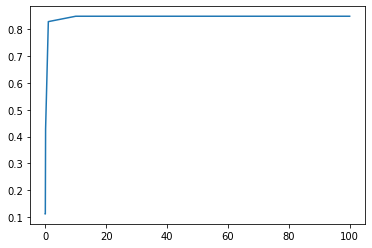

Choice of C:  10.0
Cross-validation accuracy score estimate:  0.8483850931677018


In [48]:
c_values = [0.001,0.01,0.1,1.0,10.0,100.0]

acc_scores_rbf = []
for c in c_values:
    
    clf = svm.SVC(C=c, kernel = 'rbf')
    scores = cross_val_score(clf, X_train, y_train, cv=10)
    m = scores.mean()
    acc_scores_rbf.append(m)
    
index_max = max(range(len(acc_scores_rbf)), key=acc_scores_rbf.__getitem__) # get the index of hyperparameter with max accuracy 
    
plt.plot(c_values, acc_scores_rbf)
plt.show()
h, s = c_values[index_max], max(acc_scores_rbf)
print("Choice of C: ", h)
print("Cross-validation accuracy score estimate: ", s)

In [58]:
clf = svm.SVC(C=1, kernel = 'rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
metrics.accuracy_score(y_train, y_pred)

0.9871244635193133

In [59]:
clf = svm.SVC(C=10, kernel = 'rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.84

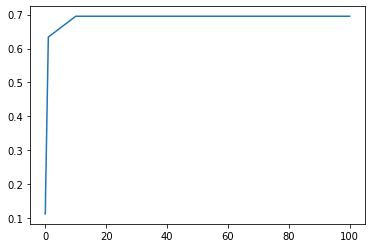

Choice of C:  10.0
Cross-validation accuracy score estimate:  0.6952929085303187


In [53]:
c_values = [0.001,0.01,0.1,1.0,10.0,100.0]

acc_scores_poly = []
for c in c_values:
    
    clf = svm.SVC(C=c, kernel = 'poly')
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    m = scores.mean()
    acc_scores_poly.append(m)
    
index_max = max(range(len(acc_scores_poly)), key=acc_scores_poly.__getitem__) # get the index of hyperparameter with max accuracy 
    
plt.plot(c_values, acc_scores_poly)
plt.show()
h, s = c_values[index_max], max(acc_scores_poly)
print("Choice of C: ", h)
print("Cross-validation accuracy score estimate: ", s)

In [54]:
clf = svm.SVC(C=10, kernel = 'poly')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
metrics.accuracy_score(y_train, y_pred)

1.0

In [55]:
clf = svm.SVC(C=10, kernel = 'poly')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.7266666666666667

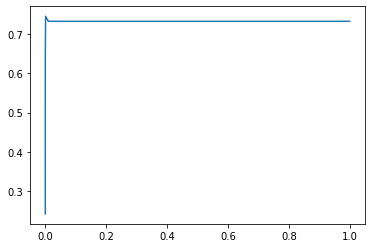

Choice of C:  0.001
Cross-validation accuracy score estimate:  0.7452723535457348


In [31]:
c_values = [0.00001,0.0001,0.001,0.01,0.1,1]

acc_scores_linear = []
for c in c_values:
    
    clf = svm.SVC(C=c, kernel = 'linear')
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    m = scores.mean()
    acc_scores_linear.append(m)
    
index_max = max(range(len(acc_scores_linear)), key=acc_scores_linear.__getitem__) # get the index of hyperparameter with max accuracy 
    
plt.plot(c_values, acc_scores_linear)
plt.show()
h, s = c_values[index_max], max(acc_scores_linear)
print("Choice of C: ", h)
print("Cross-validation accuracy score estimate: ", s)

In [56]:
clf = svm.SVC(C=0.001, kernel = 'linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
metrics.accuracy_score(y_train, y_pred)

0.9599427753934192

In [ ]:
clf = svm.SVC(C=0.001, kernel = 'linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)